In [22]:
import copy
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torch.nn.functional as F

plt.ion()

In [23]:
cudnn.benchmark = True

In [24]:
rotation = transforms.RandomChoice(
    [
        transforms.RandomRotation([-3, 3]),
        transforms.RandomRotation([87, 93]),
        transforms.RandomRotation([177, 183]),
        transforms.RandomRotation([267, 273]),
    ]
)

augmentation = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), rotation]
)

In [25]:
from pathlib import Path

data_dir = Path().resolve() / "data" / "MelanomaDetectionLabeled" / "labeled"
print("data_dir: ", data_dir)

assert data_dir.exists()

data_dir:  C:\dev_repo\ml\data\MelanomaDetectionLabeled\labeled


In [26]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


# Define a function to check if a file is actually an image.
def is_image(filename):
    if isinstance(filename, str):
        filename = Path(filename)
    return filename.suffix in [".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif"]


# C:\dev_repo\ml\data\MelanomaDetectionLabeled

In [27]:
class LabeledDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """

        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        p = Path(dir_path).resolve()
        self.img_path_list = [f for f in p.iterdir() if is_image(f)]
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):

        # Here is where the image actually gets read:
        img_path = self.img_path_list[idx]
        # img = read_image(str(img_path)).type(torch.float32)/255.0
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = int(img_path.stem.split("_")[1])

        return img, label


labeled_dataset = LabeledDataset(
    data_dir,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            augmentation,
        ]
    ),
)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_seed(123)

In [29]:
# %pwd

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch labels tensor([0, 0, 0, 1])


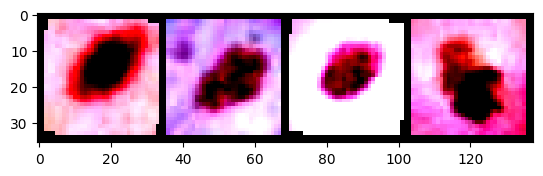

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch labels tensor([0, 0, 0, 0])


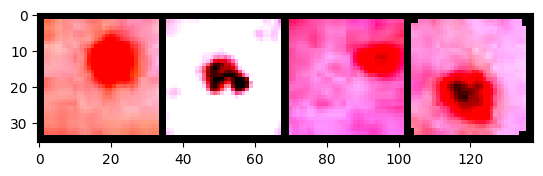

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch labels tensor([0, 1, 0, 1])


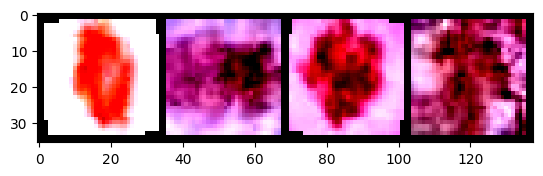

In [30]:
labeled_loader = DataLoader(labeled_dataset, batch_size=4, shuffle=True)

for batch_idx, batch in enumerate(labeled_loader):
    if batch_idx > 2:
        break

    print("Batch labels", batch[1].data)
    image_grid = torchvision.utils.make_grid(batch[0], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.pause(0.05)
    plt.show()

In [31]:
model_ft = models.resnet18(weights="DEFAULT")
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 2)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# Dataset Preparation

train_set, val_set = torch.utils.data.random_split(labeled_dataset, [0.7, 0.3])

# Instantiate the LabeledDataset class for testing
dir_test = Path().resolve() / "data" / "MelanomaDetectionLabeled" / "test"
test_set = LabeledDataset(dir_test, transform=transforms.ToTensor())

# Print the number of images in the train, validation and test sets
print("Number of images in the training set: ", len(train_set))
print("Number of images in the validation set: ", len(val_set))
print("Number of images in the test set: ", len(test_set))

Number of images in the training set:  140
Number of images in the validation set:  60
Number of images in the test set:  600


In [33]:
train_batch_size = len(train_set)
dataloaders = {
    "train": DataLoader(train_set, batch_size=train_batch_size, shuffle=True),
    "val": DataLoader(val_set, batch_size=4, shuffle=True),
}

dataset_sizes = {"train": len(train_set), "val": len(val_set)}


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [35]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100
)

Epoch 0/99
----------
train Loss: 0.7905 Acc: 0.4857
val Loss: 0.6625 Acc: 0.6167

Epoch 1/99
----------
train Loss: 0.6169 Acc: 0.6214
val Loss: 0.6103 Acc: 0.7333

Epoch 2/99
----------
train Loss: 0.4388 Acc: 0.8000
val Loss: 0.6141 Acc: 0.7167

Epoch 3/99
----------
train Loss: 0.3821 Acc: 0.8429
val Loss: 0.5237 Acc: 0.7167

Epoch 4/99
----------
train Loss: 0.3373 Acc: 0.8857
val Loss: 0.5099 Acc: 0.8167

Epoch 5/99
----------
train Loss: 0.3400 Acc: 0.8786
val Loss: 0.5138 Acc: 0.7667

Epoch 6/99
----------
train Loss: 0.3289 Acc: 0.8357
val Loss: 0.5057 Acc: 0.7500

Epoch 7/99
----------
train Loss: 0.3246 Acc: 0.8500
val Loss: 0.4847 Acc: 0.7833

Epoch 8/99
----------
train Loss: 0.3422 Acc: 0.8500
val Loss: 0.4758 Acc: 0.8167

Epoch 9/99
----------
train Loss: 0.2500 Acc: 0.8929
val Loss: 0.4996 Acc: 0.8000

Epoch 10/99
----------
train Loss: 0.3017 Acc: 0.8786
val Loss: 0.4513 Acc: 0.8667

Epoch 11/99
----------
train Loss: 0.2633 Acc: 0.9000
val Loss: 0.4600 Acc: 0.8167

Ep

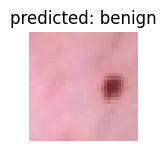

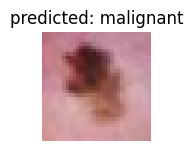

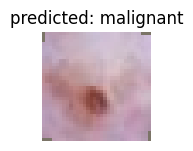

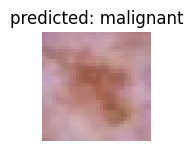

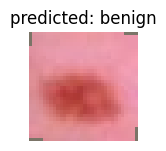

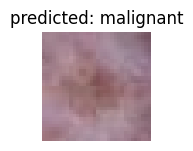

In [36]:
class_names = ["benign", "malignant"]


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_ft)

Epoch 0/199
----------
train Loss: 0.6906 Acc: 0.5357
val Loss: 0.6942 Acc: 0.5167

Epoch 1/199
----------
train Loss: 0.6972 Acc: 0.4714
val Loss: 0.6944 Acc: 0.5167

Epoch 2/199
----------
train Loss: 0.6959 Acc: 0.5357
val Loss: 0.6939 Acc: 0.5000

Epoch 3/199
----------
train Loss: 0.6932 Acc: 0.5000
val Loss: 0.6945 Acc: 0.5167

Epoch 4/199
----------
train Loss: 0.6985 Acc: 0.4357
val Loss: 0.6941 Acc: 0.5167

Epoch 5/199
----------
train Loss: 0.7000 Acc: 0.4786
val Loss: 0.6940 Acc: 0.5167

Epoch 6/199
----------
train Loss: 0.6937 Acc: 0.5786
val Loss: 0.6951 Acc: 0.5167

Epoch 7/199
----------
train Loss: 0.6958 Acc: 0.5071
val Loss: 0.6936 Acc: 0.5167

Epoch 8/199
----------
train Loss: 0.6929 Acc: 0.4714
val Loss: 0.6927 Acc: 0.5167

Epoch 9/199
----------
train Loss: 0.6993 Acc: 0.4714
val Loss: 0.6943 Acc: 0.5167

Epoch 10/199
----------
train Loss: 0.6950 Acc: 0.4929
val Loss: 0.6939 Acc: 0.5167

Epoch 11/199
----------
train Loss: 0.6877 Acc: 0.5857
val Loss: 0.6936 Acc

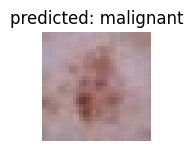

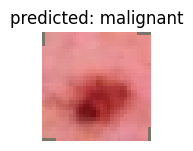

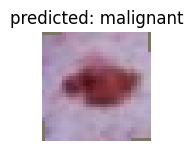

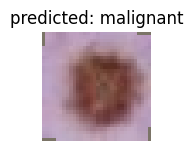

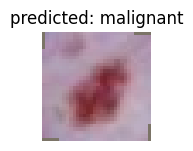

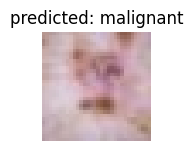

In [37]:
# My own model from scratch


class Net2(nn.Module):
    def __init__(self, img_shape=(3, 32, 32)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        dummy = torch.zeros(img_shape).unsqueeze_(0)
        flatten_size = self.cnn_stack(dummy).shape[1]
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def cnn_stack(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.cnn_stack(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        return self.fc2(x)


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)


model_scratch = Net2().to(device)
model_scratch = train_model(
    model_scratch, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200
)
visualize_model(model_scratch)